In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fq1Hw8WTgQg-EPZEK0IkLwJOa8P6J6ozEraItC4dH0pu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'kidneyprediction-donotdelete-pr-xhohtgoisowb24'
object_key = 'chronickidneydisease.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


In [3]:
df.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [5]:
df[df.duplicated()]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification


In [6]:
df.isna().sum()

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [7]:
df2 = df.dropna(axis=0)
df2


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [8]:
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [9]:
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})


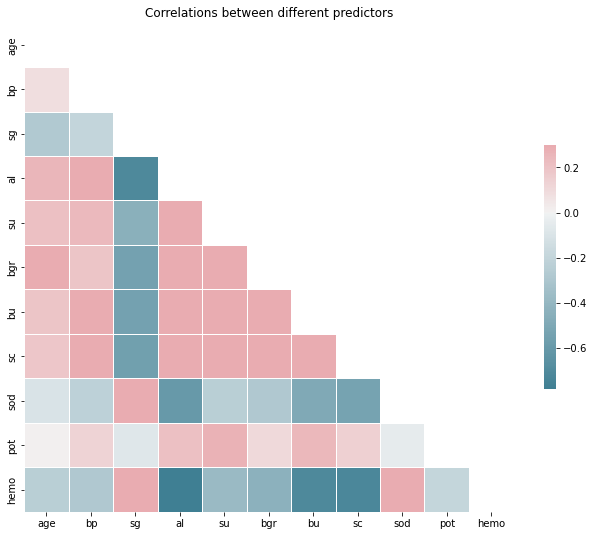

In [10]:
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
catcols=set(df2.dtypes[df2.dtypes=='O'].index.values)
catcols

{'ane',
 'appet',
 'ba',
 'cad',
 'classification',
 'dm',
 'htn',
 'pc',
 'pcc',
 'pcv',
 'pe',
 'rbc',
 'rc',
 'wc'}

In [13]:
for i in catcols:
    print("LABEL ENCODING OF:",i)
    LEi=LabelEncoder()
    print(df2[i])
    df2[i]=LEi.fit_transform(df2[i])
    print(df2[i])
    print("*"*100)

LABEL ENCODING OF: wc
3       6700
9      12100
11      4500
14     11000
20      9200
       ...  
395     6700
396     7800
397     6600
398     7200
399     6800
Name: wc, Length: 158, dtype: object
3      42
9      11
11     25
14      8
20     63
       ..
395    42
396    52
397    41
398    47
399    43
Name: wc, Length: 158, dtype: int64
****************************************************************************************************
LABEL ENCODING OF: cad
3       no
9       no
11      no
14     yes
20     yes
      ... 
395     no
396     no
397     no
398     no
399     no
Name: cad, Length: 158, dtype: object
3      0
9      0
11     0
14     1
20     1
      ..
395    0
396    0
397    0
398    0
399    0
Name: cad, Length: 158, dtype: int64
****************************************************************************************************
LABEL ENCODING OF: pc
3      abnormal
9      abnormal
11     abnormal
14     abnormal
20     abnormal
         ...   
395      norma

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['classification'],test_size = 0.33, random_state=44,stratify= df2['classification'] )

In [15]:
X_train.head()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 190 to 389
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     105 non-null    float64
 1   bp      105 non-null    float64
 2   sg      105 non-null    float64
 3   al      105 non-null    float64
 4   su      105 non-null    float64
 5   rbc     105 non-null    int64  
 6   pc      105 non-null    int64  
 7   pcc     105 non-null    int64  
 8   ba      105 non-null    int64  
 9   bgr     105 non-null    float64
 10  bu      105 non-null    float64
 11  sc      105 non-null    float64
 12  sod     105 non-null    float64
 13  pot     105 non-null    float64
 14  hemo    105 non-null    float64
 15  pcv     105 non-null    int64  
 16  wc      105 non-null    int64  
 17  rc      105 non-null    int64  
 18  htn     105 non-null    int64  
 19  dm      105 non-null    int64  
 20  cad     105 non-null    int64  
 21  appet   105 non-null    int64  
 22  

In [16]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [17]:
y_train.value_counts()


1    76
0    29
Name: classification, dtype: int64

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lgr=LogisticRegression()
lgr.fit(X_train,y_train)

LogisticRegression()

In [20]:
y_pred=lgr.predict(X_test)

In [21]:
!pip install -U ibm-watson-machine-learning

In [22]:
from ibm_watson_machine_learning import APIClient
import json


In [23]:
wml_credentials={
    "apikey":"CiuJpHjNdNw7WeT76F7JogN9dNwsjn9-CROnxedgPZza",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [24]:
wml_client=APIClient(wml_credentials)


In [25]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------------  ------------------------
ID                                    NAME                     CREATED
34ca5035-7785-4296-9c33-f99200ed82d1  kidney                   2022-11-23T12:02:37.156Z
1accd793-ad6e-49e1-a3c4-1917ca848623  kidneydiseaseprediction  2022-11-19T17:08:20.638Z
------------------------------------  -----------------------  ------------------------


In [26]:
SPACE_ID="34ca5035-7785-4296-9c33-f99200ed82d1"

In [27]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [28]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [29]:
import sklearn
sklearn.__version__

'1.0.2'

In [30]:
MODEL_NAME='kidney'
DEPLOYMENT_NAME='kidney_prediction'
DEMO_MODEL=lgr

In [31]:
software_spec_uid=wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [32]:
model_props={
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

In [33]:
model_details=wml_client.repository.store_model(
    model=DEMO_MODEL,
    meta_props=model_props,
    training_data=X_train,
    training_target=y_train
)

In [34]:
model_id=wml_client.repository.get_model_id(model_details)
model_id

'cf322ffd-c17a-4b23-8476-e508076c1229'

In [35]:
deployment_props={
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [36]:
deployment=wml_client.deployments.create(
    artifact_uid=model_id,
    meta_props=deployment_props
)



#######################################################################################

Synchronous deployment creation for uid: 'cf322ffd-c17a-4b23-8476-e508076c1229' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='5db87918-18ae-4ff2-9ec9-70c6af4a3fbf'
------------------------------------------------------------------------------------------------


